# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [89]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [90]:
# Config
IMAGE_1 = "tex_1.jpg"
IMAGE_2 = "malachai_1.jpg"

EYE_POINTS_BY_IMAGE = {
    "nutmeg.jpg": ((607, 290), (748, 370)),
    "DerekPicture.jpg": ((299,343), (439,331)),
    "malachai_1.jpg": ((1337, 1680), (1653, 1680)),
    "hawk_1.jpg": ((1284, 1743), (1596, 2040)),
    "hawk_2.jpg": ((1470, 2094), (1737, 2154)),
    "tex_1.jpg": ((1356, 1482), (1584, 1491)),
    "immune.jpg": ((504, 903), (2349, 903)),
    "engineering.jpg": ((318, 762), (2490, 771)),
}



In [91]:
# modify to where you store your project data including utils.py
datadir = Path.cwd() / "pictures"

img1_file = datadir / IMAGE_1
img2_file = datadir / IMAGE_2

img1 = np.float32(cv2.imread(img1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
img2 = np.float32(cv2.imread(img2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

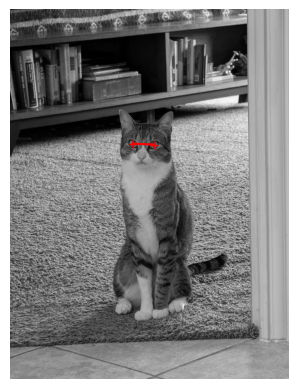

In [92]:
pts_im1 = utils.prompt_eye_selection(img1)
pts_im1 = np.array(EYE_POINTS_BY_IMAGE[IMAGE_1]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')

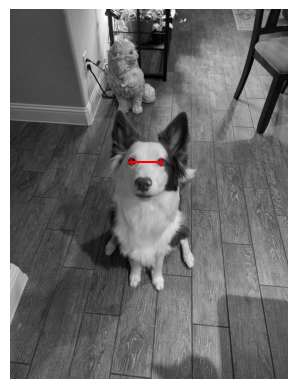

In [93]:
pts_im2 = utils.prompt_eye_selection(img2)
pts_im2 = np.array(EYE_POINTS_BY_IMAGE[IMAGE_2]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')

In [94]:
# Align images using updated alignment function
img1, img2 = utils.align_images(
    img1_file, img2_file, pts_im1, pts_im2, save_images=False
)

In [95]:
# convert to grayscale
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) / 255.0
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) / 255.0
# img1 = cv2.cvtColor(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB) / 255.0

(Text(0.5, 1.0, 'Image 2'), [], [])

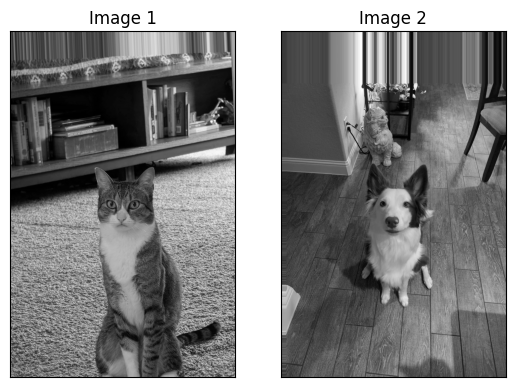

In [96]:
# Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img1, cmap="gray")
axes[0].set_title("Image 1"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img2, cmap="gray")
axes[1].set_title("Image 2"), axes[1].set_xticks([]), axes[1].set_yticks([])

In [97]:
def hybridImage(img1, img2, sigma_low, sigma_high):
    """
    Inputs:
        img1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        img2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter

    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    """
    # Per the lectures, kernel half-width is best set >= 3 * sigma, AND kernel must be odd in width
    # Ergo: K = 6 * sigma + 1
    K_low = 6 * sigma_low + 1
    K_high = 6 * sigma_high + 1

    # Compute the low-pass filter (Gaussian)
    low_pass_gaussian = cv2.getGaussianKernel(ksize=K_low, sigma=sigma_low)
    low_pass_filter = low_pass_gaussian @ low_pass_gaussian.T 

    # Compute the high-pass filter (Impulse - Gaussian)
    ## Impulse
    high_pass_impulse = np.zeros((K_high, K_high))
    high_pass_impulse[(K_high//2, K_high//2)] = 1

    ## Gaussian
    high_pass_gaussian = cv2.getGaussianKernel(ksize=K_high, sigma=sigma_high)
    high_pass_gaussian = high_pass_gaussian @ high_pass_gaussian.T

    ## Combined Kernel
    high_pass_filter = high_pass_impulse - high_pass_gaussian

    # Filter the images. ddepth=-1 matches the depth of the source image
    # BORDER_REFLECT to reduce shadows & other edge effects
    low_frequency_image = cv2.filter2D(
        src=img1,
        ddepth=-1,
        kernel=low_pass_filter,
        borderType=cv2.BORDER_REFLECT
    )
    high_frequency_image = cv2.filter2D(
        src=img2,
        ddepth=-1,
        kernel=high_pass_filter,
        borderType=cv2.BORDER_CONSTANT,
    )

    # Combine the images
    result = low_frequency_image + high_frequency_image

    return result, low_frequency_image, high_frequency_image


In [98]:
sigma_low = 20  # choose parameters that work for your images
sigma_high = 25

im_hybrid, filtered1, filtered2 = hybridImage(img1, img2, sigma_low, sigma_high)

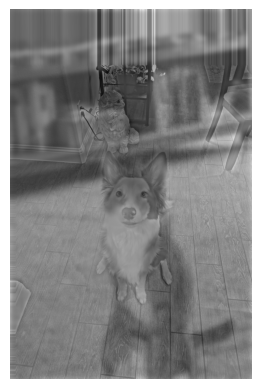

In [99]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

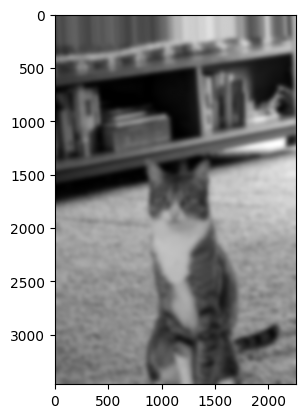

In [100]:
plt.imshow(filtered1, cmap="gray")

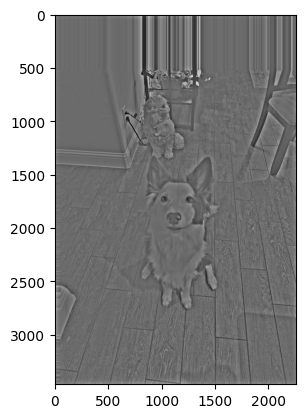

In [101]:

plt.imshow(filtered2, cmap="gray")

In [102]:
# Display FFTs (based on code provided in lecture slides)
def display_frequency_image(frequency_image):
    '''
    frequency_image: H x W floating point numpy ndarray representing image after FFT
    in grayscale
    '''
    shifted_image = np.fft.fftshift(frequency_image)
    amplitude_image = np.abs(shifted_image)
    log_amplitude_image = np.log(amplitude_image)
    fig = plt.figure()
    plt.imshow(log_amplitude_image, cmap='gray')
    plt.show()

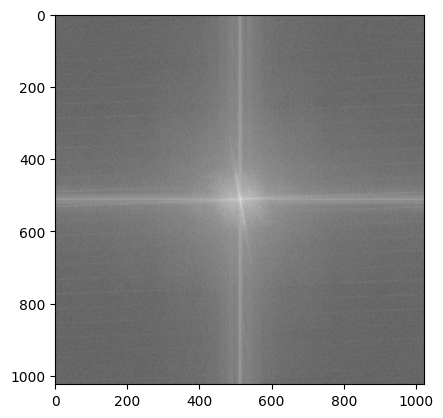

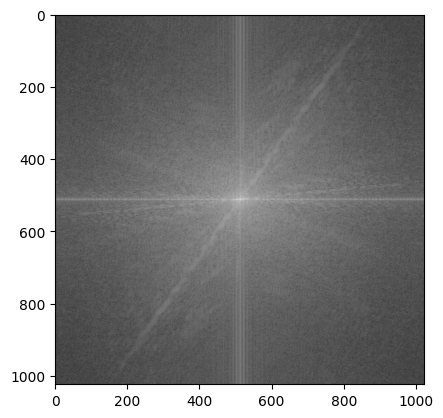

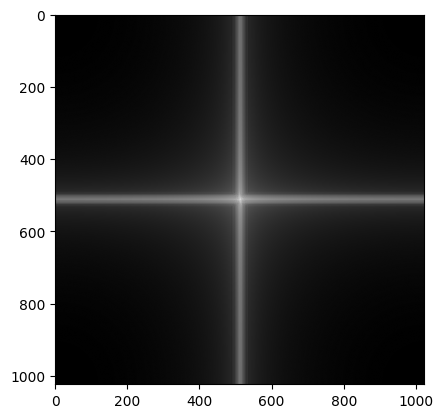

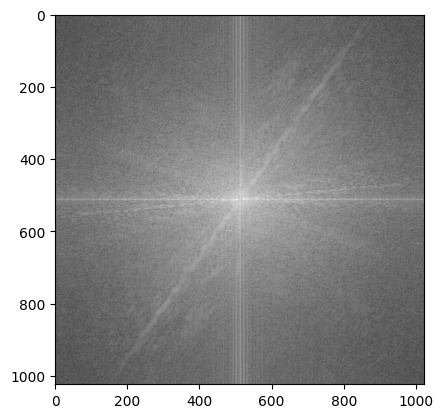

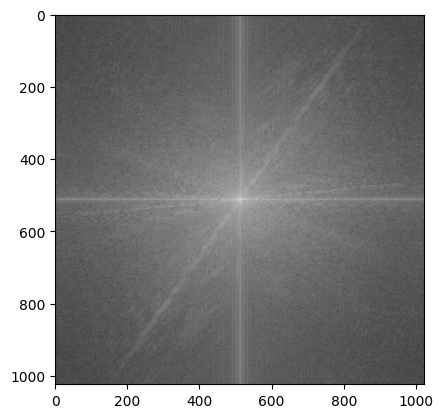

In [103]:
for image in (img1, img2, filtered1, filtered2, im_hybrid):
    display_frequency_image(np.fft.fft2(image, (1024, 1024)))


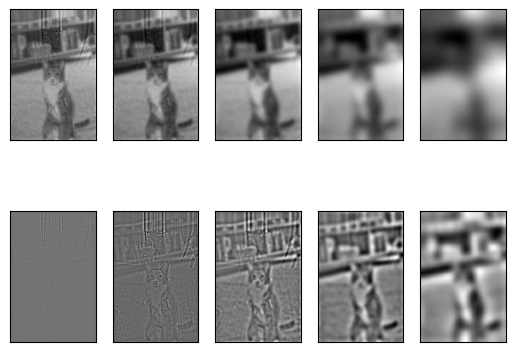

In [104]:
# Image pyramids
input_image = im_hybrid

# Create the same kernel used by opencv in their image pyramid
pyramid_sigma = 10
K = 6 * pyramid_sigma + 1
kernel = cv2.getGaussianKernel(ksize=K, sigma=pyramid_sigma)
kernel = kernel * kernel.T

def step_down(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Step 1: apply blur
    gaussian = cv2.filter2D(src=image, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REFLECT)

    # Step 2: subtract blur from source image -> laplacian
    laplacian = image - gaussian

    # Step 3: downsample both
    downsampled_gaussian = gaussian[::2, ::2]
    downsampled_laplacian = laplacian[::2, ::2]

    return downsampled_gaussian, downsampled_laplacian

gaussians, laplacians = [], []
for _ in range(5):
    input_image, laplacian_image = step_down(input_image)
    gaussians.append(input_image)
    laplacians.append(laplacian_image)

fig, axes = plt.subplots(2, len(gaussians))
for i, (g, l) in enumerate(zip(gaussians, laplacians)):
    axes[0][i].imshow(g, cmap="gray")
    axes[1][i].imshow(l, cmap="gray")
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

In [105]:
# We don't want to add a constant value to our chroma channels because they would clip at high
# values, which destroys information. Instead, resize the channel and apply a gamma function
def apply_gamma(input: np.ndarray, gamma: tuple[float, float, float]) -> np.ndarray:
    """
    Scales channels of an image by the gamma vector. Pass 1 for a channel to leave it unchanged.
    input (np.ndarray) : image to scale. Assumed to be in LAB form, uint8 values
    gamma (tuple[float]) : 1x3 scaling vector corresponding to each channel
    """
    # Convert to a 0 to 1 space
    normalized = input / (255, 255, 255)
    # Apply gamma function
    normalized = normalized ** gamma
    # Revert to uint8
    normalized = (normalized * (255, 255, 255)).astype(np.uint8)
    return normalized

#### Contrast enhancement

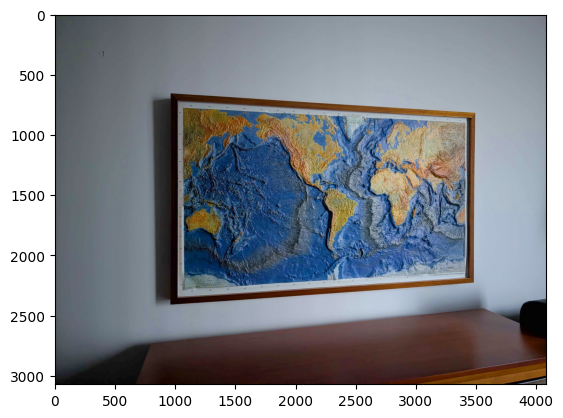

In [106]:
IMAGE = "world_map.jpg"
original_image = cv2.imread(datadir / IMAGE)
# Convert to HSV so we can access the saturation channel
hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
enhanced_image = apply_gamma(hsv_image, (1, 1, .75))
output_enhanced = cv2.cvtColor(enhanced_image, cv2.COLOR_HSV2RGB)

plt.imshow(output_enhanced)

#### Color enhancement 

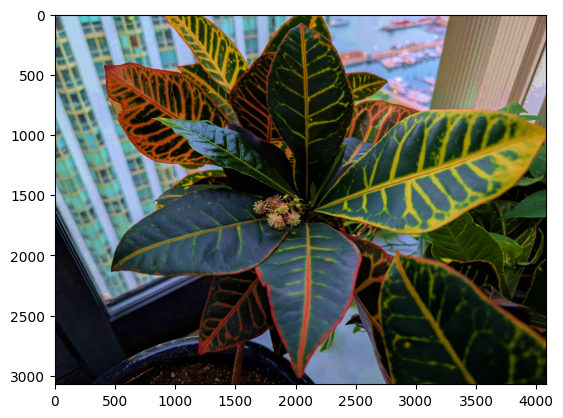

In [107]:
IMAGE = "croton.jpg"
original_image = cv2.imread(datadir / IMAGE)
# Convert to HSV so we can access the saturation channel
hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
enhanced_image = apply_gamma(hsv_image, (1, .5, 1))
output_enhanced = cv2.cvtColor(enhanced_image, cv2.COLOR_HSV2RGB)

plt.imshow(output_enhanced)


#### Color shift

In [108]:
# We don't want to add a constant value to our chroma channels because they would clip at high
# values, which destroys information. Instead, resize the channel and apply a gamma function
def apply_gamma_selective(input: np.ndarray, gamma: float, channel: int, high_band: bool) -> np.ndarray:
    """
    Scales channels of an image by the gamma vector. Pass 1 for a channel to leave it unchanged.
    input (np.ndarray) : image to scale. Assumed to be in LAB form, uint8 values
    gamma (float) : the gamma to apply to the specified channel
    channel: the channel (0, 1, or 2) to apply gamma to
    """
    gamma_vector = [1, 1, 1]
    mask_vector = [0, 0, 0] if high_band else [1, 1, 1]
    gamma_vector[channel] = gamma
    # Create a cutoff so we don't reduce the opposite color
    mask_vector[channel] = .5

    # Convert to a 0 to 1 space
    normalized = input / (255, 255, 255)
    # Apply gamma function
    if high_band:
        # If gamma is less than 1, we're increasing values in the channel
        # Therefore, mask out any values under .5
        normalized = np.where(normalized > mask_vector, normalized ** gamma_vector, normalized)
    else:
        normalized = np.where(normalized < mask_vector, normalized ** gamma_vector, normalized)

    normalized = normalized ** gamma
    # Revert to uint8
    normalized = (normalized * (255, 255, 255)).astype(np.uint8)
    return normalized

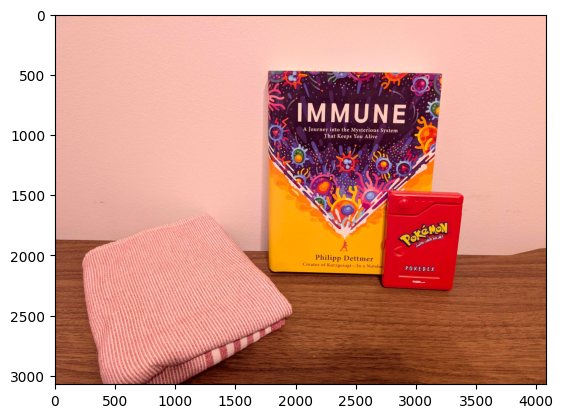

In [109]:

IMAGE = "books.jpg"
original_image = cv2.imread(datadir / IMAGE)
# Convert to LAB so we can access the a (red/green) & b (blue/yellow) channels
lab_image: np.ndarray = cv2.cvtColor(original_image, cv2.COLOR_BGR2LAB)

image_more_red = apply_gamma_selective(lab_image, .9, 1, True)
image_less_yellow = apply_gamma_selective(lab_image, 1.25, 2, False)
output_more_red = cv2.cvtColor(image_more_red, cv2.COLOR_LAB2RGB)
output_less_yellow = cv2.cvtColor(image_less_yellow, cv2.COLOR_LAB2RGB)
plt.imshow(output_more_red)
# plt.imshow(output_less_yellow)
